In this task I learn to build and train a CNN in TensorFlow for Hand Gesture Recognition as a classification problem. I use a subset of the [Sign Language MNIST dataset](https://www.kaggle.com/datamunge/sign-language-mnist).

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline

## Dataset

The SIGNS dataset here is a collection of 6 signs representing numbers from 0 to 5.

<img src="/images/SIGNS.png" style="width:800px;height:300px;">

### Load the Dataset

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:]) 
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

### Check the data

Before processing it's a good idea to get a feel of the data.

y(class) = 5


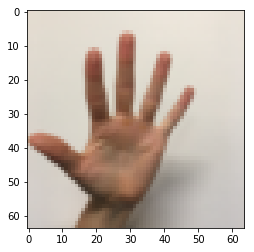

In [4]:
# Example of a picture
index = 3
plt.imshow(X_train_orig[index])
print ("y(class) = " + str(np.squeeze(Y_train_orig[:, index])))

### Normalize the Train and Test Data Values

As the range of data values is 0-255, let me divide by 255 to normalize

In [5]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.

Let me convert the labels to one-hot vectors

In [6]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [7]:
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

Let me now check the shape of the data

In [8]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


* The training set has **1080** images of dimensions **64x64** and **3** channels for RGB
* The training set has **120** images

## Build the CNN Model

This is the CNN architecture that I'm going to implement using TensorFlow.

<img src="/images/model.png" style="width:800px;height:300px;">

### Initialize Parameters
In the above architecture there are 2 convolutional layers for which I need to initialize the filter parameters.
I will initialize weights/filters $W1$ and $W2$ using `tf.contrib.layers.xavier_initializer(seed = 0)`. 

I won't worry about bias variables as TensorFlow functions take care of the bias.

Also, I will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the layers for the fully connected part automatically

In [9]:
def initialize_parameters():
    # First convolution layer has 8 filters (4x4) 3 channels (as required by input)
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    # Second convolution layer has 16 filters (2x2) 8 channels (as required by previous layer)
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    parameters = {"W1": W1, "W2": W2}
    return parameters

### Create placeholders

TensorFlow requires that I create placeholders for the input data that will be fed into my CNN compute-graph when running the session.

In [10]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    # first parameter is None for the number of training samples
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y

### Forward Propagation

Let me now build the compute graph for the above CNN model

In TensorFlow, there are built-in functions that carry out the convolution steps.

- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,s,s,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev).

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window.

- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape).

- **tf.contrib.layers.flatten(P)**: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k].

- **tf.contrib.layers.fully_connected(F, num_outputs):** given a the flattened input F, it returns the output computed using a fully connected layer.

In [11]:
def forward_propagation(X, parameters):    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function
    # 6 neurons in output layer for the 6 classes.
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)

    return Z3

### Loss Function

I will use softmax entropy loss function provided by tensorflow to calulate the loss.

- **tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y):** computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss. **This is why in the `forward_propagation`, I had `activation_fn=None`**


- **tf.reduce_mean:** computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost.

In [12]:
def compute_loss(Z3, Y):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return loss

## Train the Model 

Finally let me train the model. The model training will:
* initialize parameters
* create placeholders

then loop over:
* forward propagate
* compute loss
* optimize

To improve the training convergence, rather than including the entire set of examples in a single optimization, I will create mini batches of the examples.

Finally I will create a session and run a for loop for a number of _epochs_, get the mini-batches, and optimize the function for each mini-batch.

### Mini Batches

In [13]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    m = X.shape[0]  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### Train

In [14]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_loss = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    losses = []                                       # To keep track of the losses
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Loss function: Add loss function to tensorflow graph
    loss = compute_loss(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the loss.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_loss = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # Run the session to execute the optimizer and the loss, the feedict should contain a minibatch for (X,Y).
                _ , temp_loss = sess.run([optimizer, loss], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_loss += temp_loss / num_minibatches
                

            # Print the loss every epoch
            if print_loss == True and epoch % 5 == 0:
                print ("Loss after epoch %i: %f" % (epoch, minibatch_loss))
            if print_loss == True and epoch % 1 == 0:
                losses.append(minibatch_loss)
        
        
        # plot the cost
        plt.plot(np.squeeze(losses))
        plt.ylabel('loss')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Loss after epoch 0: 1.911429
Loss after epoch 5: 1.428720
Loss after epoch 10: 1.028124
Loss after epoch 15: 0.778874
Loss after epoch 20: 0.583801
Loss after epoch 25: 0.492565
Loss after epoch 30: 0.444330
Loss after epoch 35: 0.375112
Loss after epoch 40: 0.380745
Loss after epoch 45: 0.313442
Loss after epoch 50: 0.274036
Loss after epoch 55: 0.259923
Loss after epoch 60: 0.228567
Loss after epoch 65: 0.221553
Loss after epoch 70: 0.218500
Loss after epoch 75: 0.179913
Loss after epoch 80: 0.185880
Loss after epoch 85: 0.163463
Loss after epoch 90: 0.149464
Loss after epoch 95: 0.156074


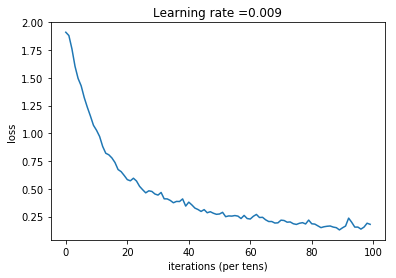

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9546296
Test Accuracy: 0.8333333


In [15]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

## Conclusion
So the trained CNN model had an accuracy of **95%** on the training data of **1080** images. Its accuracy on the test data of **120** images was about **83%**.

This is my first task on Deep Learning and I had a lot to learn including:
* Processing Image Data
* Tensorflow basics
* CNNs
* Training and Testing Neural Networks

Access to Andrew Ng's coursera course material on [CNN](https://www.coursera.org/learn/convolutional-neural-networks/home/info) was very useful for me in this task.